# Age bin Classifier Finetuned On Cellnexus Data (Curated CZI Data)
### Resource usage to conduct experiment: 64.0/72 CPUs, 4.0/4 GPUs (A100:40gb)

In [2]:
import os
os.environ["PATH"] += os.pathsep + "/gpfs/apps/icl/software/CUDA/12.2.2/nvvm/bin:/gpfs/apps/icl/software/CUDA/12.2.2/bin"
LD_LIBRARY_PATH="/apps/icl/software/CUDAcompat/12.2-535.161.08/lib"
os.environ["LD_LIBRARY_PATH"]=os.pathsep+LD_LIBRARY_PATH

In [1]:
#Import all the necessary files
import datetime
from geneformer import Classifier
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from geneformer import TranscriptomeTokenizer, DataCollatorForCellClassification 
import numpy as np


In [18]:
#Creating file name with timestamp for experiment
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "age_bins_classifier_cellnexus_blood_cell_type_as_covariate"
output_dir = f"/hpcfs/users/a1841503/trained_classifiers/agebins_classifier_v1_cellnexus/{datestamp}"
!mkdir -p $output_dir

In [15]:
#Reading the anndata object
adata=sc.read_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/age_bins/anndata/complete_age/complete_anndata.h5ad")
adata.obs.cell_type.describe()


count                                                698763
unique                                                  101
top       naive thymus-derived CD4-positive, alpha-beta ...
freq                                                  63318
Name: cell_type, dtype: object

In [16]:
adata.obs.age_category.describe()

count        698763
unique            5
top       Senior_70
freq         200559
Name: age_category, dtype: object

In [17]:
adata.obs.dataset_id.describe()

count                                   698763
unique                                      30
top       21d3e683-80a4-4d9b-bc89-ebb2df513dde
freq                                    100000
Name: dataset_id, dtype: object

Distribution of Cells In Age Bins in the Dataset
age_category
Senior_70          200559
Senior_50          175580
Young_Adulthood    128958
Senior_60          104021
Middle_Age          89645
Name: count, dtype: int64


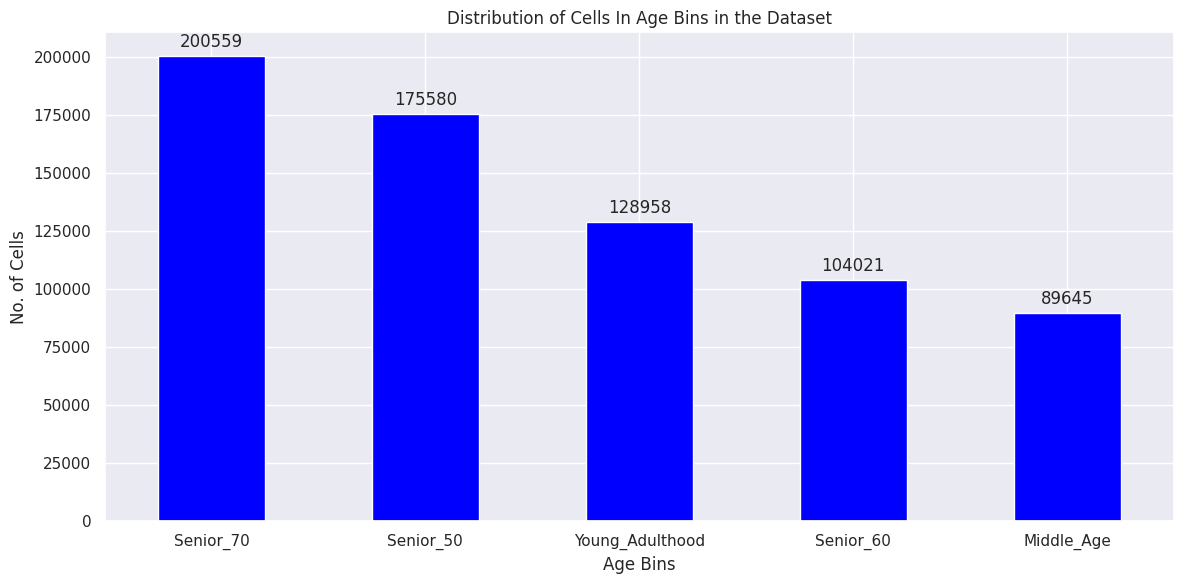

In [18]:
# Get the age distribution
age_counts = adata.obs.age_category.value_counts()
print("Distribution of Cells In Age Bins in the Dataset")
print(age_counts)

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 6))
age_counts.plot(kind='bar', ax=ax, color=['blue'])
ax.set_title('Distribution of Cells In Age Bins in the Dataset')
ax.set_xlabel('Age Bins')
ax.set_ylabel('No. of Cells')
ax.tick_params(axis='x', rotation=0)

# Add count labels on top of bars
for i, v in enumerate(age_counts.values):
    ax.text(i, v + max(age_counts.values) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

/tmp/ipykernel_806114/61198026.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset_disease_counts = adata.obs.groupby(['dataset_id', 'age_category']).size().unstack(fill_value=0)


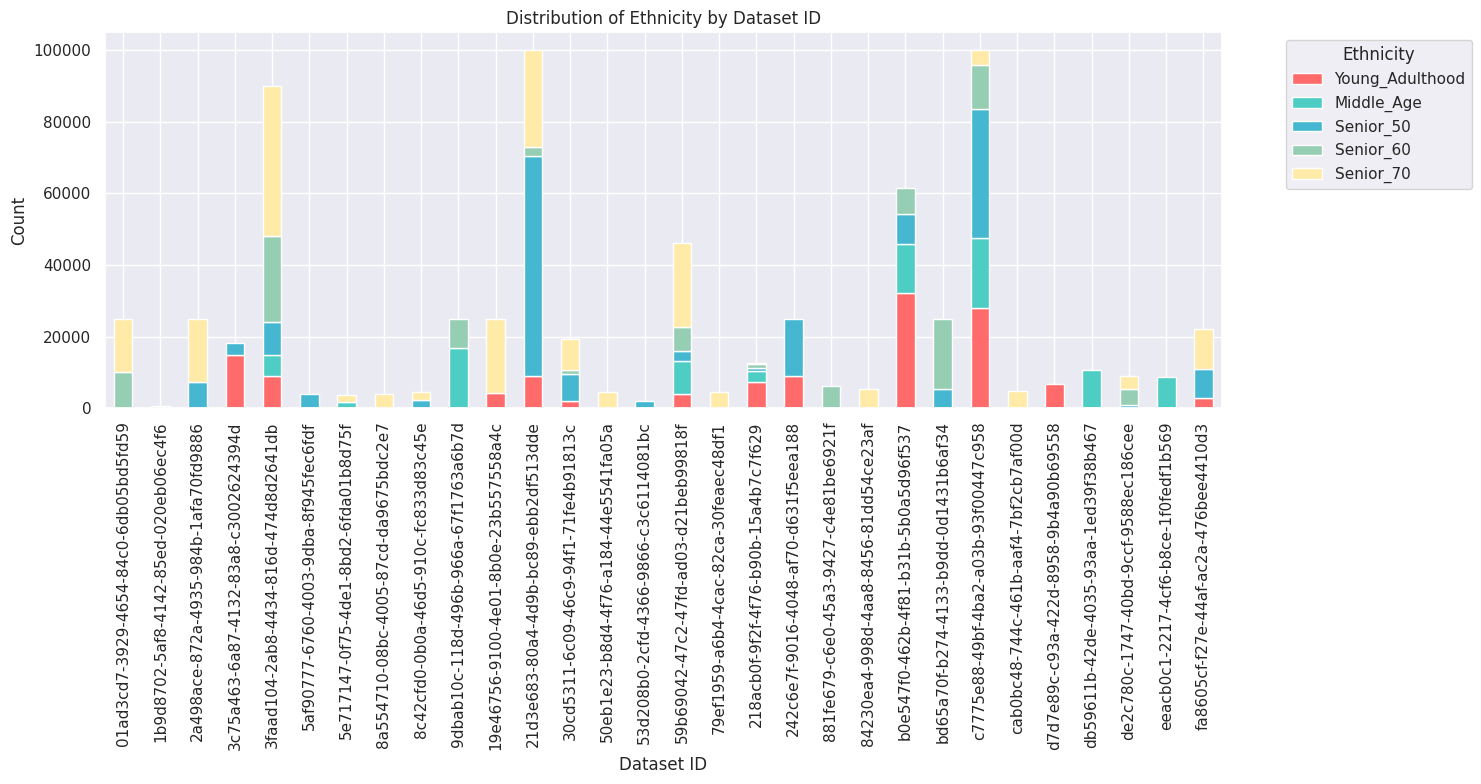

Unique dataset IDs:
['9dbab10c-118d-496b-966a-67f1763a6b7d', 'bd65a70f-b274-4133-b9dd-0d1431b6af34', '19e46756-9100-4e01-8b0e-23b557558a4c', 'd7d7e89c-c93a-422d-8958-9b4a90b69558', 'de2c780c-1747-40bd-9ccf-9588ec186cee', ..., 'c7775e88-49bf-4ba2-a03b-93f00447c958', 'cab0bc48-744c-461b-aaf4-7bf2cb7af00d', 'db59611b-42de-4035-93aa-1ed39f38b467', 'eeacb0c1-2217-4cf6-b8ce-1f0fedf1b569', 'fa8605cf-f27e-44af-ac2a-476bee4410d3']
Length: 30
Categories (30, object): ['01ad3cd7-3929-4654-84c0-6db05bd5fd59', '1b9d8702-5af8-4142-85ed-020eb06ec4f6', '2a498ace-872a-4935-984b-1afa70fd9886', '3c75a463-6a87-4132-83a8-c3002624394d', ..., 'db59611b-42de-4035-93aa-1ed39f38b467', 'de2c780c-1747-40bd-9ccf-9588ec186cee', 'eeacb0c1-2217-4cf6-b8ce-1f0fedf1b569', 'fa8605cf-f27e-44af-ac2a-476bee4410d3']


In [19]:
# Plot dataset_id vs disease
dataset_disease_counts = adata.obs.groupby(['dataset_id', 'age_category']).size().unstack(fill_value=0)

# Create a stacked bar plot with distinct colors for each ethnicity
fig, ax = plt.subplots(figsize=(15, 8))
ethnicity_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']
dataset_disease_counts.plot(kind='bar', stacked=True, ax=ax, color=ethnicity_colors[:len(dataset_disease_counts.columns)])
ax.set_title('Distribution of Ethnicity by Dataset ID')
ax.set_xlabel('Dataset ID')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Also show the unique dataset IDs
print("Unique dataset IDs:")
print(adata.obs.dataset_id.unique())

In [20]:
list(adata.obs.dataset_id.unique())

['9dbab10c-118d-496b-966a-67f1763a6b7d',
 'bd65a70f-b274-4133-b9dd-0d1431b6af34',
 '19e46756-9100-4e01-8b0e-23b557558a4c',
 'd7d7e89c-c93a-422d-8958-9b4a90b69558',
 'de2c780c-1747-40bd-9ccf-9588ec186cee',
 '01ad3cd7-3929-4654-84c0-6db05bd5fd59',
 '218acb0f-9f2f-4f76-b90b-15a4b7c7f629',
 '242c6e7f-9016-4048-af70-d631f5eea188',
 '2a498ace-872a-4935-984b-1afa70fd9886',
 '3c75a463-6a87-4132-83a8-c3002624394d',
 '1b9d8702-5af8-4142-85ed-020eb06ec4f6',
 '21d3e683-80a4-4d9b-bc89-ebb2df513dde',
 '30cd5311-6c09-46c9-94f1-71fe4b91813c',
 '3faad104-2ab8-4434-816d-474d8d2641db',
 '50eb1e23-b8d4-4f76-a184-44e5541fa05a',
 '53d208b0-2cfd-4366-9866-c3c6114081bc',
 '59b69042-47c2-47fd-ad03-d21beb99818f',
 '5af90777-6760-4003-9dba-8f945fec6fdf',
 '5e717147-0f75-4de1-8bd2-6fda01b8d75f',
 '79ef1959-a6b4-4cac-82ca-30feaec48df1',
 '84230ea4-998d-4aa8-8456-81dd54ce23af',
 '881fe679-c6e0-45a3-9427-c4e81be6921f',
 '8c42cfd0-0b0a-46d5-910c-fc833d83c45e',
 '8a554710-08bc-4005-87cd-da9675bdc2e7',
 'b0e547f0-462b-

In [5]:
# Geneformer directories for the 2048 model
gene_median_file_2048="/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/gene_median_dictionary_gc30M.pkl" 
token_dictionary_file_2048= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl"
gene_mapping_file_2048= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/ensembl_mapping_dict_gc30M.pkl"

#Defining the tokenizer
tk = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid","age_category": "age_category","cell_type": "cell_type","dataset_id": "dataset_id"},
                            model_input_size = 2048,
                            special_token = False,
                            gene_median_file=gene_median_file_2048 ,
                            token_dictionary_file= token_dictionary_file_2048,
                            gene_mapping_file= gene_mapping_file_2048)

In [6]:
#directory for the anndata object
data_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/data/age_bins/anndata/complete_age/"
#directory for the tokenized data
token_dir="/hpcfs/users/a1841503/Geneformer/cellnexus/data/age_bins/celltype_tokenized_Complete_blood/"

#tokenizing the data
tk.tokenize_data(data_directory=data_directory,
                 output_directory=token_dir, 
                 output_prefix="Age_Bins_cell_type", 
                 file_format="h5ad")

Tokenizing /hpcfs/users/a1841503/Geneformer/cellnexus/data/age_bins/anndata/complete_age/complete_anndata.h5ad


/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/hpcfs/users/a1841503/Geneformer/cellnexus/data/age_bins/anndata/complete_age/complete_anndata.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


In [8]:
filter_data_dict={"age_category":["Young_Adulthood","Middle_Age", "Senior_50", "Senior_60", "Senior_70"]}
training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
}

# OF NOTE: model_version should match version of model to be used (V1 or V2) to use the correct token dictionary
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "age_category", "states": "all"},
                filter_data=filter_data_dict,
                training_args=training_args,
                max_ncells=None,
                freeze_layers = 2,
                num_crossval_splits = 1,
                forward_batch_size=100,
                nproc=16)

In [ ]:
datset_id_list=['9dbab10c-118d-496b-966a-67f1763a6b7d',
 'bd65a70f-b274-4133-b9dd-0d1431b6af34',
 '19e46756-9100-4e01-8b0e-23b557558a4c',
 'd7d7e89c-c93a-422d-8958-9b4a90b69558',
 'de2c780c-1747-40bd-9ccf-9588ec186cee',
 '01ad3cd7-3929-4654-84c0-6db05bd5fd59',
 '218acb0f-9f2f-4f76-b90b-15a4b7c7f629',
 '242c6e7f-9016-4048-af70-d631f5eea188',
 '2a498ace-872a-4935-984b-1afa70fd9886',
 '3c75a463-6a87-4132-83a8-c3002624394d',
 '1b9d8702-5af8-4142-85ed-020eb06ec4f6',
 '21d3e683-80a4-4d9b-bc89-ebb2df513dde',
 '30cd5311-6c09-46c9-94f1-71fe4b91813c',
 '3faad104-2ab8-4434-816d-474d8d2641db',
 '50eb1e23-b8d4-4f76-a184-44e5541fa05a',
 '53d208b0-2cfd-4366-9866-c3c6114081bc',
 '59b69042-47c2-47fd-ad03-d21beb99818f',
 '5af90777-6760-4003-9dba-8f945fec6fdf',
 '5e717147-0f75-4de1-8bd2-6fda01b8d75f',
 '79ef1959-a6b4-4cac-82ca-30feaec48df1',
 '84230ea4-998d-4aa8-8456-81dd54ce23af',
 '881fe679-c6e0-45a3-9427-c4e81be6921f',
 '8c42cfd0-0b0a-46d5-910c-fc833d83c45e',
 '8a554710-08bc-4005-87cd-da9675bdc2e7',
 'b0e547f0-462b-4f81-b31b-5b0a5d96f537',
 'c7775e88-49bf-4ba2-a03b-93f00447c958',
 'cab0bc48-744c-461b-aaf4-7bf2cb7af00d',
 'db59611b-42de-4035-93aa-1ed39f38b467',
 'eeacb0c1-2217-4cf6-b8ce-1f0fedf1b569',
 'fa8605cf-f27e-44af-ac2a-476bee4410d3']

In [10]:
# Manually balanced splits
# argument attr_to_split set to "dataset_id" and attr_to_balance set to ["sex"]
#Categories (11, object): ['01ad3cd7-3929-4654-84c0-6db05bd5fd59', '2a498ace-872a-4935-984b-1afa70fd9886', '3faad104-2ab8-4434-816d-474d8d2641db', '19e46756-9100-4e01-8b0e-23b557558a4c', ..., '59b69042-47c2-47fd-ad03-d21beb99818f', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '242c6e7f-9016-4048-af70-d631f5eea188', 'b0e547f0-462b-4f81-b31b-5b0a5d96f537']
test_ids= ['c7775e88-49bf-4ba2-a03b-93f00447c958','3faad104-2ab8-4434-816d-474d8d2641db']
train_ids=['9dbab10c-118d-496b-966a-67f1763a6b7d','bd65a70f-b274-4133-b9dd-0d1431b6af34','19e46756-9100-4e01-8b0e-23b557558a4c','d7d7e89c-c93a-422d-8958-9b4a90b69558','de2c780c-1747-40bd-9ccf-9588ec186cee','01ad3cd7-3929-4654-84c0-6db05bd5fd59','218acb0f-9f2f-4f76-b90b-15a4b7c7f629','242c6e7f-9016-4048-af70-d631f5eea188','2a498ace-872a-4935-984b-1afa70fd9886','3c75a463-6a87-4132-83a8-c3002624394d','1b9d8702-5af8-4142-85ed-020eb06ec4f6','21d3e683-80a4-4d9b-bc89-ebb2df513dde','30cd5311-6c09-46c9-94f1-71fe4b91813c','50eb1e23-b8d4-4f76-a184-44e5541fa05a','53d208b0-2cfd-4366-9866-c3c6114081bc','59b69042-47c2-47fd-ad03-d21beb99818f','5af90777-6760-4003-9dba-8f945fec6fdf','5e717147-0f75-4de1-8bd2-6fda01b8d75f','79ef1959-a6b4-4cac-82ca-30feaec48df1','84230ea4-998d-4aa8-8456-81dd54ce23af','881fe679-c6e0-45a3-9427-c4e81be6921f','8c42cfd0-0b0a-46d5-910c-fc833d83c45e','8a554710-08bc-4005-87cd-da9675bdc2e7','b0e547f0-462b-4f81-b31b-5b0a5d96f537','cab0bc48-744c-461b-aaf4-7bf2cb7af00d','db59611b-42de-4035-93aa-1ed39f38b467','eeacb0c1-2217-4cf6-b8ce-1f0fedf1b569','fa8605cf-f27e-44af-ac2a-476bee4410d3']
split_id_dict={"attr_key": "dataset_id",
                            "train": train_ids,
                            "test": test_ids}
attr_to_balance =["age_category"] 
input_data_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/age_bins/celltype_tokenized_Complete_blood/Age_Bins_cell_type.dataset"
output_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/data/age_bins/celltype_tokenized_Complete_blood/"
# Example input_data_file for 30M model: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
cc.prepare_data(input_data_file=input_data_file,
                output_directory=output_dir,
                output_prefix=output_prefix,
                split_id_dict=split_id_dict,
                attr_to_balance=attr_to_balance,)

In [11]:
model_directory="/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000"

# V1 model: https://huggingface.co/ctheodoris/Geneformer/blob/main/Geneformer-V1-10M/model.safetensors
all_metrics = cc.validate(model_directory=model_directory,  # OF NOTE: SET TO V1 MODEL ABOVE, PROVIDE V1 MODEL PATH HERE
                          prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled_train.dataset",
                          id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          n_hyperopt_trials=10)
                          # to optimize hyperparameters, set n_hyperopt_trials=100 (or alternative desired # of trials)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



2025-09-10 22:08:46,802	INFO worker.py:1841 -- Started a local Ray instance.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to

== Status ==
Current time: 2025-09-10 22:08:49 (running for 00:00:00.13)
Using FIFO scheduling algorithm.
Logical resource usage: 0/72 CPUs, 0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 1/10 (1 PENDING)
+---------------------+----------+-------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc   |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |       |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+-------+-----------------+---------------------+---------------

(_objective pid=2489093) Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
(_objective pid=2489093) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=2489093) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/37689 [00:00<?, ?it/s]
(_objective pid=2489093) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy 

(_objective pid=2489266) {'loss': 1.0004, 'grad_norm': 14.631319999694824, 'learning_rate': 5.087366917633654e-05, 'epoch': 0.1}


 13%|█▎        | 4807/37689 [09:44<1:06:23,  8.25it/s] [repeated 165x across cluster]


== Status ==
Current time: 2025-09-10 22:18:49 (running for 00:10:00.16)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+--

 20%|█▉        | 7516/37689 [15:05<1:00:33,  8.31it/s] [repeated 164x across cluster]


(_objective pid=2490071) {'loss': 0.5507, 'grad_norm': 3.450822591781616, 'learning_rate': 0.00044754075606142133, 'epoch': 0.2} [repeated 4x across cluster]


 20%|██        | 7565/37689 [15:18<1:01:32,  8.16it/s] [repeated 163x across cluster]


(_objective pid=2489663) {'loss': 0.5153, 'grad_norm': 5.082563877105713, 'learning_rate': 0.0003288068999152105, 'epoch': 0.2} [repeated 3x across cluster]


 26%|██▌       | 9750/37689 [19:42<56:30,  8.24it/s] [repeated 166x across cluster]


== Status ==
Current time: 2025-09-10 22:28:49 (running for 00:20:00.16)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+--

 30%|██▉       | 11214/37689 [22:40<51:14,  8.61it/s] [repeated 167x across cluster]


(_objective pid=2490071) {'loss': 0.4646, 'grad_norm': 6.116875171661377, 'learning_rate': 0.00039160880655409174, 'epoch': 0.3}


 30%|██▉       | 11284/37689 [22:50<53:42,  8.19it/s] [repeated 164x across cluster]


(_objective pid=2489266) {'loss': 0.5585, 'grad_norm': 11.816733360290527, 'learning_rate': 4.231425357179401e-05, 'epoch': 0.3}


 30%|███       | 11307/37689 [22:53<53:41,  8.19it/s]


(_objective pid=2489663) {'loss': 0.4515, 'grad_norm': 10.984808921813965, 'learning_rate': 0.0002877046742583358, 'epoch': 0.3} [repeated 2x across cluster]


 39%|███▉      | 14669/37689 [29:41<46:58,  8.17it/s] [repeated 166x across cluster]


== Status ==
Current time: 2025-09-10 22:38:49 (running for 00:30:00.25)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+--

 40%|███▉      | 14961/37689 [30:16<46:32,  8.14it/s] [repeated 163x across cluster]


(_objective pid=2490071) {'loss': 0.4185, 'grad_norm': 13.099732398986816, 'learning_rate': 0.000335676857046762, 'epoch': 0.4}


 40%|███▉      | 15045/37689 [30:26<46:13,  8.16it/s] [repeated 165x across cluster]


(_objective pid=2489266) {'loss': 0.4839, 'grad_norm': 7.755018711090088, 'learning_rate': 3.516655153323443e-05, 'epoch': 0.4}


 40%|████      | 15143/37689 [30:37<45:17,  8.30it/s] [repeated 163x across cluster]


(_objective pid=2489663) {'loss': 0.394, 'grad_norm': 1.3462393283843994, 'learning_rate': 0.00024660244860146116, 'epoch': 0.4} [repeated 2x across cluster]


 50%|████▉     | 18681/37689 [37:48<38:48,  8.16it/s] [repeated 167x across cluster]


(_objective pid=2490071) {'loss': 0.3744, 'grad_norm': 3.4117631912231445, 'learning_rate': 0.00027974490753943234, 'epoch': 0.5}


 50%|████▉     | 18806/37689 [38:03<38:34,  8.16it/s] [repeated 163x across cluster]


(_objective pid=2489266) {'loss': 0.4305, 'grad_norm': 8.170269012451172, 'learning_rate': 2.7039410453932124e-05, 'epoch': 0.5}


 50%|█████     | 18890/37689 [38:13<36:19,  8.63it/s] [repeated 163x across cluster]


(_objective pid=2489663) {'loss': 0.3653, 'grad_norm': 6.662998199462891, 'learning_rate': 0.00020550022294458647, 'epoch': 0.5} [repeated 2x across cluster]


 52%|█████▏    | 19602/37689 [39:39<36:52,  8.17it/s] [repeated 165x across cluster]


== Status ==
Current time: 2025-09-10 22:48:50 (running for 00:40:00.34)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+--

 60%|█████▉    | 22438/37689 [45:24<29:36,  8.59it/s] [repeated 162x across cluster]


(_objective pid=2490071) {'loss': 0.3415, 'grad_norm': 2.043910026550293, 'learning_rate': 0.00022381295803210267, 'epoch': 0.6}


 60%|█████▉    | 22478/37689 [45:39<31:09,  8.14it/s] [repeated 167x across cluster]


(_objective pid=2489266) {'loss': 0.4054, 'grad_norm': 21.886085510253906, 'learning_rate': 1.8779110288758694e-05, 'epoch': 0.6}


 60%|██████    | 22689/37689 [45:55<29:08,  8.58it/s] [repeated 160x across cluster]


(_objective pid=2489663) {'loss': 0.3332, 'grad_norm': 2.6039836406707764, 'learning_rate': 0.0001643979972877118, 'epoch': 0.6} [repeated 2x across cluster]


 65%|██████▌   | 24560/37689 [49:43<26:58,  8.11it/s] [repeated 166x across cluster]


== Status ==
Current time: 2025-09-10 22:58:50 (running for 00:50:00.35)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+--

 69%|██████▉   | 26143/37689 [52:56<22:51,  8.42it/s] [repeated 165x across cluster]


(_objective pid=2490071) {'loss': 0.3077, 'grad_norm': 1.94270658493042, 'learning_rate': 0.000167881008524773, 'epoch': 0.7}


 70%|██████▉   | 26310/37689 [53:16<23:00,  8.24it/s] [repeated 163x across cluster]


(_objective pid=2489266) {'loss': 0.3806, 'grad_norm': 1.329850673675537, 'learning_rate': 1.124579686055607e-05, 'epoch': 0.7}


 70%|███████   | 26395/37689 [53:21<22:57,  8.20it/s] [repeated 164x across cluster]


(_objective pid=2489093) {'loss': 0.606, 'grad_norm': 11.555098533630371, 'learning_rate': 3.126111660535516e-06, 'epoch': 0.7}


 70%|███████   | 26435/37689 [53:32<22:20,  8.40it/s] [repeated 166x across cluster]


(_objective pid=2489663) {'loss': 0.3069, 'grad_norm': 11.506202697753906, 'learning_rate': 0.00012329577163083713, 'epoch': 0.7}


 78%|███████▊  | 29485/37689 [59:42<16:44,  8.17it/s] [repeated 166x across cluster]


== Status ==
Current time: 2025-09-10 23:08:50 (running for 01:00:00.42)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+--

 80%|████████  | 30152/37689 [1:00:29<15:20,  8.19it/s]


(_objective pid=2490071) {'loss': 0.2808, 'grad_norm': 5.062034606933594, 'learning_rate': 0.00011194905901744328, 'epoch': 0.8}


 80%|███████▉  | 30069/37689 [1:00:53<15:33,  8.16it/s] [repeated 166x across cluster]


(_objective pid=2489266) {'loss': 0.3653, 'grad_norm': 15.64039421081543, 'learning_rate': 5.2239147957734136e-06, 'epoch': 0.8}


 80%|███████▉  | 30111/37689 [1:00:58<15:22,  8.22it/s] [repeated 162x across cluster]


(_objective pid=2489093) {'loss': 0.5958, 'grad_norm': 5.7457098960876465, 'learning_rate': 1.4488311573330805e-06, 'epoch': 0.8}


 80%|████████  | 30282/37689 [1:01:14<15:22,  8.03it/s] [repeated 164x across cluster]


(_objective pid=2489663) {'loss': 0.2778, 'grad_norm': 5.725171089172363, 'learning_rate': 8.219354597396246e-05, 'epoch': 0.8}


 89%|████████▉ | 33623/37689 [1:08:05<08:20,  8.13it/s] [repeated 166x across cluster]


(_objective pid=2490071) {'loss': 0.2539, 'grad_norm': 1.2391942739486694, 'learning_rate': 5.601710951011361e-05, 'epoch': 0.9}


 90%|████████▉ | 33832/37689 [1:08:30<07:53,  8.14it/s] [repeated 164x across cluster]


(_objective pid=2489266) {'loss': 0.3576, 'grad_norm': 22.51494026184082, 'learning_rate': 1.3405232327103114e-06, 'epoch': 0.9}


 90%|████████▉ | 33916/37689 [1:08:40<07:42,  8.16it/s] [repeated 161x across cluster]


(_objective pid=2489093) {'loss': 0.5949, 'grad_norm': 16.231956481933594, 'learning_rate': 3.712861661619308e-07, 'epoch': 0.9}


 90%|█████████ | 33999/37689 [1:08:50<07:34,  8.13it/s] [repeated 165x across cluster]


(_objective pid=2489663) {'loss': 0.2486, 'grad_norm': 0.8998607993125916, 'learning_rate': 4.1091320317087765e-05, 'epoch': 0.9}


 92%|█████████▏| 34495/37689 [1:09:44<06:16,  8.48it/s]


== Status ==
Current time: 2025-09-10 23:18:50 (running for 01:10:00.45)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+--

 99%|█████████▉| 37245/37689 [1:15:39<00:54,  8.14it/s]
(_objective pid=2490071) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=2490071)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
(_objective pid=2490071) 
 99%|█████████▉| 37247/37689 [1:15:39<00:52,  8.35it/s]
(_objective pid=2490071) 
 99%|█████████▉| 37248/37689 [1:15:39<00:53,  8.27it/s]
(_objective pid=2490071) 
 99%|█████████▉| 37249/37689 [1:15:39<00:53,  8.25it/s]
(_objective pid=2490071) 
 99%|█████████▉| 37373/37689 [1:15:40<00:37,  8.41it/s]
(_objective pid=2490071) 
 99%|█████████▉| 37251/37689 [1:15:39<00:53,  8.15it/s]
(_objective pid=2490071) 
 99%|█████████▉| 37253/37689 [1:15:40<00:53,  8.16it/s]


(_objective pid=2490071) {'eval_loss': 0.21967318654060364, 'eval_accuracy': 0.9194983460987388, 'eval_macro_f1': 0.9116396277203247, 'eval_runtime': 205.2555, 'eval_samples_per_second': 275.427, 'eval_steps_per_second': 22.957, 'epoch': 1.0}


(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489663) 
                                                       
100%|██████████| 4712/4712 [03:25<00:00, 23.84it/s]
                                                   
(_objective pid=2489093) 
(_objective pid=2489663) 


(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2490071) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-10_22-08-49/_objective_0fae9c58_4_learning_rate=0.0005,lr_scheduler_type=polynomial,num_train_epochs=1,per_device_train_batch_size=12,seed=98._2025-09-10_22-09-01/checkpoint_000000)
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2489093) 
(_objective pid=2489266) 
100%|██████████| 37689/37689 [1:19:01<00:00,  7.95it/s]
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489663) 


(_objective pid=2490071) {'train_runtime': 4741.796, 'train_samples_per_second': 95.377, 'train_steps_per_second': 7.948, 'train_loss': 0.4076984873840013, 'epoch': 1.0}


(_objective pid=2489093) 
(_objective pid=2489663) 
(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2489093) 
(_objective pid=2489663) 
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2489093) 
(_objective pid=2489663) 
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489663) 
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective pid=2489093) 
(_objective pid=2489266) 
(_objective 

(_objective pid=2489266) {'eval_loss': 0.3336726725101471, 'eval_accuracy': 0.869297578405533, 'eval_macro_f1': 0.8607875972472436, 'eval_runtime': 199.9347, 'eval_samples_per_second': 282.757, 'eval_steps_per_second': 23.568, 'epoch': 1.0}


(_objective pid=2489093) 
 96%|█████████▌| 4526/4712 [03:12<00:07, 24.01it/s]
(_objective pid=2489663) 
(_objective pid=2489093) 
 96%|█████████▌| 4529/4712 [03:12<00:07, 23.78it/s]
(_objective pid=2489266) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-10_22-08-49/_objective_b1236974_2_learning_rate=0.0001,lr_scheduler_type=cosine,num_train_epochs=1,per_device_train_batch_size=12,seed=64.4993_2025-09-10_22-08-55/checkpoint_000000)
(_objective pid=2489663) 
(_objective pid=2489663) 
(_objective pid=2489093) 
100%|██████████| 37689/37689 [1:19:31<00:00,  7.90it/s]
(_objective pid=2489093) 
 96%|█████████▌| 4535/4712 [03:12<00:07, 23.60it/s]
(_objective pid=2489663) 


(_objective pid=2489266) {'train_runtime': 4771.4791, 'train_samples_per_second': 94.784, 'train_steps_per_second': 7.899, 'train_loss': 0.49941331172660625, 'epoch': 1.0}


(_objective pid=2489093) 
 96%|█████████▋| 4538/4712 [03:12<00:07, 23.79it/s]
(_objective pid=2489663) 
(_objective pid=2489093) 
 96%|█████████▋| 4541/4712 [03:12<00:07, 23.75it/s]
(_objective pid=2489663) 
(_objective pid=2489663) 
(_objective pid=2489093) 
 96%|█████████▋| 4544/4712 [03:13<00:07, 23.75it/s]
(_objective pid=2489093) 
 96%|█████████▋| 4547/4712 [03:13<00:06, 23.66it/s]
(_objective pid=2489663) 
(_objective pid=2489093) 
 97%|█████████▋| 4550/4712 [03:13<00:06, 23.67it/s]
(_objective pid=2489663) 
(_objective pid=2489093) 
 97%|█████████▋| 4553/4712 [03:13<00:06, 24.08it/s]
(_objective pid=2489663) 
(_objective pid=2489093) 
 97%|█████████▋| 4556/4712 [03:13<00:06, 24.07it/s]
(_objective pid=2489663) 
(_objective pid=2489093) 
 97%|█████████▋| 4559/4712 [03:13<00:06, 23.86it/s]
(_objective pid=2489663) 
(_objective pid=2489093) 
 97%|█████████▋| 4562/4712 [03:13<00:06, 23.63it/s]
(_objective pid=2489663) 
(_objective pid=2489093) 
 97%|█████████▋| 4565/4712 [03:13<00:0

(_objective pid=2489093) {'eval_loss': 0.5749479532241821, 'eval_accuracy': 0.7712132736631702, 'eval_macro_f1': 0.7672890939057371, 'eval_runtime': 200.21, 'eval_samples_per_second': 282.368, 'eval_steps_per_second': 23.535, 'epoch': 1.0}


(_objective pid=2489093) 
                                                       
100%|██████████| 4712/4712 [03:20<00:00, 23.41it/s]
                                                   
  0%|          | 23/37689 [00:03<1:15:17,  8.34it/s] [repeated 58x across cluster]
(_objective pid=2489663) 
 91%|█████████▏| 4310/4712 [03:05<00:17, 23.18it/s]
(_objective pid=2489663) 
 92%|█████████▏| 4313/4712 [03:05<00:17, 23.17it/s]
(_objective pid=2489093) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-10_22-08-49/_objective_bdbaf4f3_1_learning_rate=0.0000,lr_scheduler_type=cosine,num_train_epochs=1,per_device_train_batch_size=12,seed=42.9524_2025-09-10_22-08-49/checkpoint_000000)
(_objective pid=2489663) 
 92%|█████████▏| 4316/4712 [03:05<00:17, 23.21it/

(_objective pid=2489093) {'train_runtime': 4779.4603, 'train_samples_per_second': 94.626, 'train_steps_per_second': 7.886, 'train_loss': 0.701131563845303, 'epoch': 1.0}


100%|██████████| 37689/37689 [1:19:39<00:00,  7.89it/s]
(_objective pid=2489663) 
 92%|█████████▏| 4319/4712 [03:05<00:17, 23.06it/s]
(_objective pid=2489663) 
 92%|█████████▏| 4322/4712 [03:05<00:16, 23.01it/s]
(_objective pid=2489663) 
 92%|█████████▏| 4325/4712 [03:05<00:16, 23.07it/s]
(_objective pid=2489663) 
 92%|█████████▏| 4328/4712 [03:05<00:16, 22.97it/s]
(_objective pid=2489663) 
 92%|█████████▏| 4331/4712 [03:05<00:16, 23.05it/s]
(_objective pid=2489663) 
  0%|          | 0/37689 [00:00<?, ?it/s]
(_objective pid=2489663) 
 92%|█████████▏| 4337/4712 [03:06<00:16, 23.12it/s]
(_objective pid=2683323) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=2683323) Detected kernel version 4.18.0, 

== Status ==
Current time: 2025-09-10 23:28:50 (running for 01:20:00.51)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 0fae9c58 with eval_macro_f1=0.9116396277203247 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0005310454203961903, 'weight_decay': 0.06570720011303367, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 1911.1172166692195, 'seed': 98.84364458775254, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 8/10 (1 PENDING, 4 RUNNING, 3 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | statu

(_objective pid=2489663) 
 94%|█████████▍| 4442/4712 [03:10<00:11, 23.22it/s]
(_objective pid=2489663) 
 94%|█████████▍| 4445/4712 [03:10<00:11, 23.51it/s]
(_objective pid=2489663) 
 94%|█████████▍| 4448/4712 [03:10<00:11, 23.70it/s]
(_objective pid=2489663) 
 94%|█████████▍| 4451/4712 [03:11<00:11, 23.71it/s]
(_objective pid=2489663) 
 95%|█████████▍| 4454/4712 [03:11<00:11, 23.42it/s]
(_objective pid=2489663) 
 95%|█████████▍| 4457/4712 [03:11<00:10, 23.31it/s]
(_objective pid=2489663) 
 95%|█████████▍| 4460/4712 [03:11<00:10, 23.26it/s]
(_objective pid=2489663) 
 95%|█████████▍| 4463/4712 [03:11<00:10, 23.18it/s]
(_objective pid=2489663) 
 95%|█████████▍| 4466/4712 [03:11<00:10, 23.21it/s]
(_objective pid=2489663) 
 95%|█████████▍| 4469/4712 [03:11<00:10, 23.21it/s]
(_objective pid=2489663) 
 95%|█████████▍| 4472/4712 [03:11<00:10, 23.16it/s]
(_objective pid=2489663) 
 95%|█████████▍| 4475/4712 [03:12<00:10, 23.22it/s]
(_objective pid=2489663) 
 95%|█████████▌| 4478/4712 [03:12<00:1

(_objective pid=2489663) {'eval_loss': 0.2126024216413498, 'eval_accuracy': 0.9220632197123804, 'eval_macro_f1': 0.9154877482189452, 'eval_runtime': 202.2939, 'eval_samples_per_second': 279.46, 'eval_steps_per_second': 23.293, 'epoch': 1.0}


                                                       
100%|██████████| 4712/4712 [03:22<00:00, 23.21it/s]
                                                   
(_objective pid=2489663) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-10_22-08-49/_objective_4847e999_3_learning_rate=0.0004,lr_scheduler_type=linear,num_train_epochs=1,per_device_train_batch_size=12,seed=95.5961_2025-09-10_22-08-58/checkpoint_000000)


(_objective pid=2489663) {'train_runtime': 4796.0305, 'train_samples_per_second': 94.299, 'train_steps_per_second': 7.858, 'train_loss': 0.3897587927677837, 'epoch': 1.0}


  1%|          | 194/37689 [00:24<1:16:58,  8.12it/s] [repeated 123x across cluster]
(_objective pid=2684875) Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
(_objective pid=2684875) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=2684875) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/37689 [00:00<?, ?it/s]/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneforme

(_objective pid=2681891) {'loss': 0.8462, 'grad_norm': 4.881559371948242, 'learning_rate': 0.0005607530697465024, 'epoch': 0.1}


 10%|█         | 3803/37689 [07:41<1:08:34,  8.23it/s] [repeated 165x across cluster]


(_objective pid=2683323) {'loss': 0.8577, 'grad_norm': 7.720451831817627, 'learning_rate': 0.0006525854187691245, 'epoch': 0.1}


 10%|█         | 3845/37689 [07:46<1:05:53,  8.56it/s] [repeated 164x across cluster]


(_objective pid=2683992) {'loss': 0.8428, 'grad_norm': 6.186087131500244, 'learning_rate': 0.0002730574295851565, 'epoch': 0.1}


 11%|█         | 4012/37689 [08:06<1:06:23,  8.45it/s] [repeated 167x across cluster]


(_objective pid=2684875) {'loss': 0.8415, 'grad_norm': 4.645131587982178, 'learning_rate': 0.00039645860706855106, 'epoch': 0.1}


 13%|█▎        | 5017/37689 [10:08<1:06:47,  8.15it/s] [repeated 157x across cluster]


== Status ==
Current time: 2025-09-10 23:38:50 (running for 01:30:00.55)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status    

 20%|██        | 7538/37689 [15:13<1:01:18,  8.20it/s]


(_objective pid=2681891) {'loss': 0.5677, 'grad_norm': 6.084194660186768, 'learning_rate': 0.0005278885113185255, 'epoch': 0.2}


 20%|█▉        | 7515/37689 [15:14<1:01:37,  8.16it/s] [repeated 167x across cluster]


(_objective pid=2683323) {'loss': 0.6089, 'grad_norm': 9.702447891235352, 'learning_rate': 0.0005800849015715764, 'epoch': 0.2}
(_objective pid=2683992) {'loss': 0.5096, 'grad_norm': 3.5828464031219482, 'learning_rate': 0.00025754080441489624, 'epoch': 0.2}


 20%|██        | 7725/37689 [15:31<1:00:52,  8.20it/s] [repeated 166x across cluster]


(_objective pid=2684875) {'loss': 0.5264, 'grad_norm': 3.943915367126465, 'learning_rate': 0.00035241746349421826, 'epoch': 0.2}


 26%|██▋       | 9977/37689 [20:08<55:54,  8.26it/s] [repeated 162x across cluster]


== Status ==
Current time: 2025-09-10 23:48:50 (running for 01:40:00.61)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status    

 30%|██▉       | 11278/37689 [22:46<53:10,  8.28it/s] [repeated 165x across cluster]


(_objective pid=2681891) {'loss': 0.4976, 'grad_norm': 6.303588390350342, 'learning_rate': 0.00046914445231627076, 'epoch': 0.3}


 30%|███       | 11320/37689 [22:51<53:36,  8.20it/s] [repeated 162x across cluster]


(_objective pid=2683992) {'loss': 0.42, 'grad_norm': 5.553020000457764, 'learning_rate': 0.00022923563602944252, 'epoch': 0.3}


 30%|███       | 11362/37689 [22:56<52:52,  8.30it/s] [repeated 165x across cluster]


(_objective pid=2683323) {'loss': 0.5377, 'grad_norm': 13.536251068115234, 'learning_rate': 0.0005075843843740283, 'epoch': 0.3}


 31%|███       | 11572/37689 [23:21<53:15,  8.17it/s] [repeated 165x across cluster]


(_objective pid=2684875) {'loss': 0.4551, 'grad_norm': 6.795436382293701, 'learning_rate': 0.0003083763199198854, 'epoch': 0.3}


 39%|███▉      | 14837/37689 [30:03<46:36,  8.17it/s] [repeated 166x across cluster]


== Status ==
Current time: 2025-09-10 23:58:50 (running for 01:50:00.68)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status    

 40%|███▉      | 14963/37689 [30:18<44:49,  8.45it/s] [repeated 167x across cluster]


(_objective pid=2681891) {'loss': 0.4477, 'grad_norm': 8.656864166259766, 'learning_rate': 0.0003907349844623727, 'epoch': 0.4}


 40%|████      | 15131/37689 [30:33<45:29,  8.26it/s] [repeated 160x across cluster]


(_objective pid=2683323) {'loss': 0.4937, 'grad_norm': 2.9094839096069336, 'learning_rate': 0.00043508386717648037, 'epoch': 0.4} [repeated 2x across cluster]


 41%|████      | 15341/37689 [30:59<45:25,  8.20it/s] [repeated 165x across cluster]


(_objective pid=2684875) {'loss': 0.4049, 'grad_norm': 1.0030567646026611, 'learning_rate': 0.0002643351763455526, 'epoch': 0.4}


 50%|████▉     | 18828/37689 [38:01<38:30,  8.16it/s] [repeated 164x across cluster]


(_objective pid=2681891) {'loss': 0.4024, 'grad_norm': 2.44869065284729, 'learning_rate': 0.00030095445502262676, 'epoch': 0.5}


 50%|█████     | 18912/37689 [38:11<38:08,  8.20it/s] [repeated 166x across cluster]


(_objective pid=2683323) {'loss': 0.4514, 'grad_norm': 9.420666694641113, 'learning_rate': 0.0003625833499789323, 'epoch': 0.5} [repeated 2x across cluster]


 51%|█████     | 19122/37689 [38:36<37:55,  8.16it/s] [repeated 166x across cluster]


(_objective pid=2684875) {'loss': 0.375, 'grad_norm': 9.005746841430664, 'learning_rate': 0.00022029403277121982, 'epoch': 0.5}


 53%|█████▎    | 19880/37689 [40:08<35:59,  8.25it/s] [repeated 165x across cluster]


== Status ==
Current time: 2025-09-11 00:08:50 (running for 02:00:00.73)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status    

 60%|█████▉    | 22610/37689 [45:38<31:09,  8.07it/s] [repeated 165x across cluster]


(_objective pid=2681891) {'loss': 0.363, 'grad_norm': 2.2096314430236816, 'learning_rate': 0.000209300070256203, 'epoch': 0.6}


 60%|██████    | 22694/37689 [45:48<30:42,  8.14it/s] [repeated 166x across cluster]


(_objective pid=2683323) {'loss': 0.4157, 'grad_norm': 5.632723331451416, 'learning_rate': 0.0002900828327813842, 'epoch': 0.6} [repeated 2x across cluster]


 61%|██████    | 22905/37689 [46:14<30:01,  8.21it/s] [repeated 165x across cluster]


(_objective pid=2684875) {'loss': 0.3403, 'grad_norm': 1.7756105661392212, 'learning_rate': 0.00017625288919688703, 'epoch': 0.6}


 66%|██████▌   | 24835/37689 [50:07<25:09,  8.51it/s] [repeated 163x across cluster]


== Status ==
Current time: 2025-09-11 00:18:50 (running for 02:10:00.79)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status    

 70%|██████▉   | 26347/37689 [53:10<22:28,  8.41it/s] [repeated 166x across cluster]


(_objective pid=2683992) {'loss': 0.2733, 'grad_norm': 10.72529411315918, 'learning_rate': 6.153192760856955e-05, 'epoch': 0.7}


 70%|██████▉   | 26381/37689 [53:26<22:40,  8.31it/s] [repeated 164x across cluster]


(_objective pid=2683323) {'loss': 0.3926, 'grad_norm': 2.5439701080322266, 'learning_rate': 0.00021758231558383618, 'epoch': 0.7} [repeated 2x across cluster]


 71%|███████   | 26683/37689 [53:51<21:57,  8.35it/s] [repeated 161x across cluster]


(_objective pid=2684875) {'loss': 0.3229, 'grad_norm': 5.760200023651123, 'learning_rate': 0.0001322117456225542, 'epoch': 0.7}


 79%|███████▉  | 29785/37689 [1:00:07<15:43,  8.38it/s] [repeated 164x across cluster]


== Status ==
Current time: 2025-09-11 00:28:50 (running for 02:20:00.83)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status    

 80%|███████▉  | 30080/37689 [1:00:43<15:28,  8.20it/s] [repeated 167x across cluster]


(_objective pid=2683992) {'loss': 0.2528, 'grad_norm': 3.104055166244507, 'learning_rate': 2.8615426083096292e-05, 'epoch': 0.8}


 80%|████████  | 30289/37689 [1:01:08<14:57,  8.24it/s] [repeated 166x across cluster]


(_objective pid=2683323) {'loss': 0.3485, 'grad_norm': 3.4199790954589844, 'learning_rate': 0.00014508179838628807, 'epoch': 0.8} [repeated 2x across cluster]


 81%|████████  | 30499/37689 [1:01:34<14:37,  8.19it/s] [repeated 164x across cluster]


(_objective pid=2684875) {'loss': 0.2872, 'grad_norm': 7.015169620513916, 'learning_rate': 8.817060204822138e-05, 'epoch': 0.8}


 90%|████████▉ | 33858/37689 [1:08:20<07:46,  8.22it/s] [repeated 166x across cluster]


(_objective pid=2683992) {'loss': 0.2307, 'grad_norm': 14.1060209274292, 'learning_rate': 7.348023040282885e-06, 'epoch': 0.9}


 90%|████████▉ | 33736/37689 [1:08:21<08:03,  8.17it/s] [repeated 163x across cluster]


(_objective pid=2681891) {'loss': 0.258, 'grad_norm': 4.453991413116455, 'learning_rate': 1.4973047592600581e-05, 'epoch': 0.9}


 90%|█████████ | 34068/37689 [1:08:46<07:21,  8.20it/s] [repeated 165x across cluster]


(_objective pid=2683323) {'loss': 0.3032, 'grad_norm': 11.095259666442871, 'learning_rate': 7.258128118874005e-05, 'epoch': 0.9}


 91%|█████████ | 34277/37689 [1:09:11<06:57,  8.17it/s] [repeated 165x across cluster]


(_objective pid=2684875) {'loss': 0.2553, 'grad_norm': 11.172425270080566, 'learning_rate': 4.4129458473888564e-05, 'epoch': 0.9}


 92%|█████████▏| 34590/37689 [1:10:04<06:20,  8.14it/s]


== Status ==
Current time: 2025-09-11 00:38:50 (running for 02:30:00.87)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status    

100%|█████████▉| 37621/37689 [1:15:55<00:08,  8.13it/s]
(_objective pid=2683992) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=2683992)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
 99%|█████████▉| 37442/37689 [1:15:51<00:30,  8.13it/s]
(_objective pid=2683992) 
 99%|█████████▉| 37443/37689 [1:15:51<00:30,  8.10it/s]
(_objective pid=2683992) 
 99%|█████████▉| 37237/37689 [1:15:26<00:55,  8.17it/s]
(_objective pid=2683992) 
 99%|█████████▉| 37446/37689 [1:15:51<00:29,  8.10it/s]
(_objective pid=2683992) 
 99%|█████████▉| 37447/37689 [1:15:51<00:29,  8.10it/s]
(_objective pid=2683992) 
100%|█████████▉| 37627/37689 [1:15:56<00:07,  8.52it/s]
(_objective pid=2683992) 


(_objective pid=2683992) {'eval_loss': 0.21101166307926178, 'eval_accuracy': 0.9213910459377709, 'eval_macro_f1': 0.9142456533344069, 'eval_runtime': 195.1397, 'eval_samples_per_second': 289.705, 'eval_steps_per_second': 24.147, 'epoch': 1.0}


(_objective pid=2683323) 
                                                       
100%|██████████| 4712/4712 [03:15<00:00, 24.06it/s]
                                                   
(_objective pid=2681891) 
 94%|█████████▎| 4409/4712 [03:06<00:12, 23.83it/s]
(_objective pid=2683323) 
(_objective pid=2683992) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-10_22-08-49/_objective_ef8d119c_7_learning_rate=0.0003,lr_scheduler_type=cosine,num_train_epochs=1,per_device_train_batch_size=12,seed=5.3380,_2025-09-10_23-28-40/checkpoint_000000)
(_objective pid=2684875) 
(_objective pid=2681891) 
 94%|█████████▎| 4412/4712 [03:06<00:12, 23.75it/s]
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2681891) 
100%|██████████| 37689/37689

(_objective pid=2683992) {'train_runtime': 4739.0382, 'train_samples_per_second': 95.433, 'train_steps_per_second': 7.953, 'train_loss': 0.37711546436170035, 'epoch': 1.0}


(_objective pid=2681891) 
 94%|█████████▍| 4421/4712 [03:07<00:12, 23.60it/s]
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2681891) 
 94%|█████████▍| 4424/4712 [03:07<00:12, 23.65it/s]
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2681891) 
 94%|█████████▍| 4427/4712 [03:07<00:12, 23.67it/s]
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2681891) 
 94%|█████████▍| 4430/4712 [03:07<00:11, 23.59it/s]
(_objective pid=2684875) 
(_objective pid=2681891) 
 94%|█████████▍| 4433/4712 [03:07<00:11, 23.72it/s]
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2681891) 
 94%|█████████▍| 4436/4712 [03:07<00:11, 23.57it/s]
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2681891) 
 94%|█████████▍| 4439/4712 [03:08<00:11, 23.73it/s]
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2681891) 
 94%|█████████▍| 4442/4712 [03:08<00:1

(_objective pid=2681891) {'eval_loss': 0.2313127964735031, 'eval_accuracy': 0.9145101091397945, 'eval_macro_f1': 0.9064494712706607, 'eval_runtime': 199.6737, 'eval_samples_per_second': 283.127, 'eval_steps_per_second': 23.599, 'epoch': 1.0}


(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2681891) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-10_22-08-49/_objective_265feebf_5_learning_rate=0.0006,lr_scheduler_type=cosine,num_train_epochs=1,per_device_train_batch_size=12,seed=64.5957_2025-09-10_22-09-04/checkpoint_000000)
(_objective pid=2683323) 
(_objective pid=2684875) 


(_objective pid=2681891) {'train_runtime': 4764.3304, 'train_samples_per_second': 94.926, 'train_steps_per_second': 7.911, 'train_loss': 0.42220066010536067, 'epoch': 1.0}


100%|██████████| 37689/37689 [1:19:24<00:00,  7.91it/s]
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
 89%|████████▉ | 4184/4712 [02:58<00:22, 23.40it/s] [repeated 80x across cluster]
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_objective pid=2684875) 
(_objective pid=2683323) 
(_ob

(_objective pid=2683323) {'eval_loss': 0.2497815042734146, 'eval_accuracy': 0.9061963808748872, 'eval_macro_f1': 0.8977102465297447, 'eval_runtime': 200.8776, 'eval_samples_per_second': 281.43, 'eval_steps_per_second': 23.457, 'epoch': 1.0}


                                                       
100%|██████████| 4712/4712 [03:20<00:00, 23.37it/s]
                                                   
(_objective pid=2684875) 
(_objective pid=2683323) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-10_22-08-49/_objective_15009ea6_6_learning_rate=0.0007,lr_scheduler_type=polynomial,num_train_epochs=1,per_device_train_batch_size=12,seed=58._2025-09-10_23-28-22/checkpoint_000000)
(_objective pid=2684875) 


(_objective pid=2683323) {'train_runtime': 4782.616, 'train_samples_per_second': 94.563, 'train_steps_per_second': 7.88, 'train_loss': 0.4679381412472804, 'epoch': 1.0}


100%|██████████| 37689/37689 [1:19:42<00:00,  7.88it/s]
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
  0%|          | 151/37689 [00:18<1:15:08,  8.33it/s] [repeated 124x across cluster]
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(_objective pid=2684875) 
(

== Status ==
Current time: 2025-09-11 00:48:50 (running for 02:40:00.96)
Using FIFO scheduling algorithm.
Logical resource usage: 48.0/72 CPUs, 3.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 10/10 (3 RUNNING, 7 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+-----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc   

(_objective pid=2684875) 
 99%|█████████▉| 4664/4712 [03:18<00:02, 23.40it/s]
(_objective pid=2684875) 
 99%|█████████▉| 4667/4712 [03:18<00:01, 23.44it/s]
(_objective pid=2684875) 
 99%|█████████▉| 4670/4712 [03:18<00:01, 23.35it/s]
(_objective pid=2684875) 
  1%|          | 305/37689 [00:37<1:15:10,  8.29it/s] [repeated 84x across cluster]
(_objective pid=2684875) 
 99%|█████████▉| 4676/4712 [03:18<00:01, 23.36it/s]
(_objective pid=2684875) 
 99%|█████████▉| 4679/4712 [03:19<00:01, 23.43it/s]
(_objective pid=2684875) 
 99%|█████████▉| 4682/4712 [03:19<00:01, 23.38it/s]
(_objective pid=2684875) 
 99%|█████████▉| 4685/4712 [03:19<00:01, 23.80it/s]
(_objective pid=2684875) 
 99%|█████████▉| 4688/4712 [03:19<00:01, 23.62it/s]
(_objective pid=2684875) 
100%|█████████▉| 4691/4712 [03:19<00:00, 23.39it/s]
(_objective pid=2684875) 
100%|█████████▉| 4694/4712 [03:19<00:00, 23.32it/s]
(_objective pid=2684875) 
100%|█████████▉| 4697/4712 [03:19<00:00, 23.26it/s]
(_objective pid=2684875) 
100%|█

(_objective pid=2684875) {'eval_loss': 0.21359173953533173, 'eval_accuracy': 0.9220278421452957, 'eval_macro_f1': 0.9152202179670317, 'eval_runtime': 200.4943, 'eval_samples_per_second': 281.968, 'eval_steps_per_second': 23.502, 'epoch': 1.0}


(_objective pid=2684875) 
100%|█████████▉| 4709/4712 [03:20<00:00, 23.42it/s]
                                                       
100%|██████████| 4712/4712 [03:20<00:00, 23.42it/s]
                                                   
(_objective pid=2684875) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-10_22-08-49/_objective_b66715fe_8_learning_rate=0.0004,lr_scheduler_type=polynomial,num_train_epochs=1,per_device_train_batch_size=12,seed=58._2025-09-10_23-28-48/checkpoint_000000)


(_objective pid=2684875) {'train_runtime': 4782.7682, 'train_samples_per_second': 94.56, 'train_steps_per_second': 7.88, 'train_loss': 0.4037430727389167, 'epoch': 1.0}


 10%|▉         | 3722/37689 [07:28<1:08:30,  8.26it/s] [repeated 84x across cluster]


(_objective pid=2917539) {'loss': 1.1709, 'grad_norm': 8.68165397644043, 'learning_rate': 1.0611070602687583e-05, 'epoch': 0.1}


 14%|█▍        | 5294/37689 [10:37<1:05:35,  8.23it/s] [repeated 83x across cluster]


== Status ==
Current time: 2025-09-11 00:58:50 (running for 02:50:01.06)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+-----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc   

 20%|█▉        | 7531/37689 [15:06<1:00:30,  8.31it/s] [repeated 84x across cluster]


(_objective pid=2917539) {'loss': 0.8992, 'grad_norm': 10.428759574890137, 'learning_rate': 9.85563431627886e-06, 'epoch': 0.2} [repeated 2x across cluster]


 27%|██▋       | 10274/37689 [20:36<56:10,  8.13it/s] [repeated 78x across cluster]


== Status ==
Current time: 2025-09-11 01:08:50 (running for 03:00:01.07)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+-----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc   

 30%|██▉       | 11268/37689 [22:36<53:23,  8.25it/s] [repeated 80x across cluster]


(_objective pid=2917539) {'loss': 0.8047, 'grad_norm': 18.726926803588867, 'learning_rate': 8.662671931744641e-06, 'epoch': 0.3} [repeated 2x across cluster]


 40%|███▉      | 15042/37689 [30:09<45:46,  8.25it/s] [repeated 83x across cluster]


(_objective pid=2917539) {'loss': 0.751, 'grad_norm': 15.434584617614746, 'learning_rate': 7.150054311767814e-06, 'epoch': 0.4} [repeated 2x across cluster]


 40%|████      | 15253/37689 [30:34<45:09,  8.28it/s] [repeated 84x across cluster]


== Status ==
Current time: 2025-09-11 01:18:50 (running for 03:10:01.13)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+-----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc   

 50%|████▉     | 18840/37689 [37:46<36:57,  8.50it/s] [repeated 82x across cluster]


(_objective pid=2917539) {'loss': 0.7095, 'grad_norm': 8.449108123779297, 'learning_rate': 5.467235911985399e-06, 'epoch': 0.5} [repeated 2x across cluster]


 54%|█████▎    | 20232/37689 [40:33<35:48,  8.12it/s] [repeated 84x across cluster]


== Status ==
Current time: 2025-09-11 01:28:50 (running for 03:20:01.17)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+-----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc   

 60%|█████▉    | 22597/37689 [45:17<30:27,  8.26it/s] [repeated 82x across cluster]


(_objective pid=2917539) {'loss': 0.6869, 'grad_norm': 11.91867733001709, 'learning_rate': 3.7804879066544465e-06, 'epoch': 0.6} [repeated 2x across cluster]


 67%|██████▋   | 25253/37689 [50:37<24:19,  8.52it/s] [repeated 81x across cluster]


== Status ==
Current time: 2025-09-11 01:38:50 (running for 03:30:01.21)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+-----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc   

 70%|██████▉   | 26350/37689 [52:49<22:54,  8.25it/s] [repeated 84x across cluster]


(_objective pid=2917539) {'loss': 0.669, 'grad_norm': 14.69726848602295, 'learning_rate': 2.2564697354140546e-06, 'epoch': 0.7} [repeated 2x across cluster]


 80%|███████▉  | 30147/37689 [1:00:26<15:12,  8.26it/s] [repeated 84x across cluster]


(_objective pid=2917539) {'loss': 0.6582, 'grad_norm': 11.305840492248535, 'learning_rate': 1.045762287416606e-06, 'epoch': 0.8} [repeated 2x across cluster]


 80%|████████  | 30231/37689 [1:00:36<14:48,  8.40it/s] [repeated 85x across cluster]


== Status ==
Current time: 2025-09-11 01:48:50 (running for 03:40:01.26)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+-----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc   

 90%|████████▉ | 33904/37689 [1:07:57<07:37,  8.27it/s] [repeated 84x across cluster]


(_objective pid=2918237) {'loss': 0.3047, 'grad_norm': 6.72417688369751, 'learning_rate': 9.322187507566573e-05, 'epoch': 0.9} [repeated 2x across cluster]


 94%|█████████▎| 35250/37689 [1:10:37<04:53,  8.30it/s]


== Status ==
Current time: 2025-09-11 01:58:51 (running for 03:50:01.32)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+-----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc   

100%|█████████▉| 37683/37689 [1:15:31<00:00,  8.23it/s]
(_objective pid=2918237) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=2918237)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
(_objective pid=2918237) 
100%|█████████▉| 37684/37689 [1:15:31<00:00,  8.24it/s]
(_objective pid=2918237) 
100%|█████████▉| 37686/37689 [1:15:31<00:00,  8.20it/s]
(_objective pid=2918237) 
100%|█████████▉| 37687/37689 [1:15:32<00:00,  8.23it/s]
(_objective pid=2918237) 
100%|█████████▉| 37688/37689 [1:15:32<00:00,  7.87it/s]
(_objective pid=2918237) 
  0%|          | 14/4712 [00:00<03:06, 25.13it/s]
(_objective pid=2918237) 
  0%|          | 17/4712 [00:00<03:09, 24.80it/s]
(_objective 

(_objective pid=2918237) {'eval_loss': 0.2520284354686737, 'eval_accuracy': 0.9051881202129729, 'eval_macro_f1': 0.8963846775655586, 'eval_runtime': 194.603, 'eval_samples_per_second': 290.504, 'eval_steps_per_second': 24.213, 'epoch': 1.0}
(_objective pid=2917539) {'loss': 0.6468, 'grad_norm': 14.776703834533691, 'learning_rate': 2.6798972952782464e-07, 'epoch': 0.9}


                                                       
100%|██████████| 4712/4712 [03:14<00:00, 24.11it/s]
                                                   
(_objective pid=2917539) 
 99%|█████████▉| 4682/4712 [03:13<00:01, 24.06it/s]
(_objective pid=2918237) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-10_22-08-49/_objective_39e727f3_10_learning_rate=0.0009,lr_scheduler_type=polynomial,num_train_epochs=1,per_device_train_batch_size=12,seed=0._2025-09-11_00-48-00/checkpoint_000000)
(_objective pid=2917539) 
 99%|█████████▉| 4685/4712 [03:13<00:01, 24.45it/s]
(_objective pid=2917539) 
100%|██████████| 37689/37689 [1:18:44<00:00,  7.98it/s]
(_objective pid=2917539) 
100%|█████████▉| 4691/4712 [03:14<00:00, 24.00it/s]


(_objective pid=2918237) {'train_runtime': 4724.9698, 'train_samples_per_second': 95.717, 'train_steps_per_second': 7.977, 'train_loss': 0.4795888487647258, 'epoch': 1.0}


(_objective pid=2917539) 
100%|█████████▉| 4694/4712 [03:14<00:00, 23.93it/s]
(_objective pid=2917539) 
100%|█████████▉| 4697/4712 [03:14<00:00, 23.88it/s]
(_objective pid=2917539) 
100%|█████████▉| 4700/4712 [03:14<00:00, 23.88it/s]
(_objective pid=2917539) 
100%|█████████▉| 4703/4712 [03:14<00:00, 24.11it/s]
(_objective pid=2917539) 
100%|█████████▉| 4706/4712 [03:14<00:00, 24.07it/s]
(_objective pid=2917539) 
                                                       
100%|██████████| 4712/4712 [03:14<00:00, 24.05it/s]
2025-09-11 02:06:59,986	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-10_22-08-49' in 0.0068s.
2025-09-11 02:06:59,990	INFO tune.py:1041 -- Total run time: 14290.31 seconds (14290.29 seconds for the tuning lo

== Status ==
Current time: 2025-09-11 02:06:59 (running for 03:58:10.30)
Using FIFO scheduling algorithm.
Logical resource usage: 16.0/72 CPUs, 1.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 4847e999 with eval_macro_f1=0.9154877482189452 and parameters={'num_train_epochs': 1, 'learning_rate': 0.0004039337857072534, 'weight_decay': 0.17623296612206843, 'lr_scheduler_type': 'linear', 'warmup_steps': 649.6851248660857, 'seed': 95.59613063720622, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_22-08-43_631140_2482370/artifacts/2025-09-10_22-08-49/_objective_2025-09-10_22-08-49/driver_artifacts
Number of trials: 10/10 (10 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+-----------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc             

100%|██████████| 37689/37689 [1:18:47<00:00,  7.97it/s]


In [21]:
cc

In [13]:
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "age_category", "states": "all"},
                forward_batch_size=50,
                nproc=16)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [28]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory="/hpcfs/users/a1841503/trained_classifiers/agebins_classifier_v1_cellnexus/250910214929/250910_geneformer_cellClassifier_age_bins_classifier_cellnexus_blood_cell_type_as_covariate/ksplit1/run-ef8d119c/checkpoint-37689",
        id_class_dict_file="/hpcfs/users/a1841503/trained_classifiers/agebins_classifier_v1_cellnexus/250910214929/age_bins_classifier_cellnexus_blood_cell_type_as_covariate_id_class_dict.pkl",
        test_data_file="/hpcfs/users/a1841503/trained_classifiers/agebins_classifier_v1_cellnexus/250910214929/age_bins_classifier_cellnexus_blood_cell_type_as_covariate_labeled_test.dataset",
        output_directory="/hpcfs/users/a1841503/trained_classifiers/agebins_classifier_v1_cellnexus/250910214929/",
        output_prefix=output_prefix,
    )

  0%|          | 0/3800 [00:00<?, ?it/s]

Parameter 'function'=<function preprocess_classifier_batch.<locals>.pad_label_example at 0x7f148c913100> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


<Figure size 1000x1000 with 0 Axes>

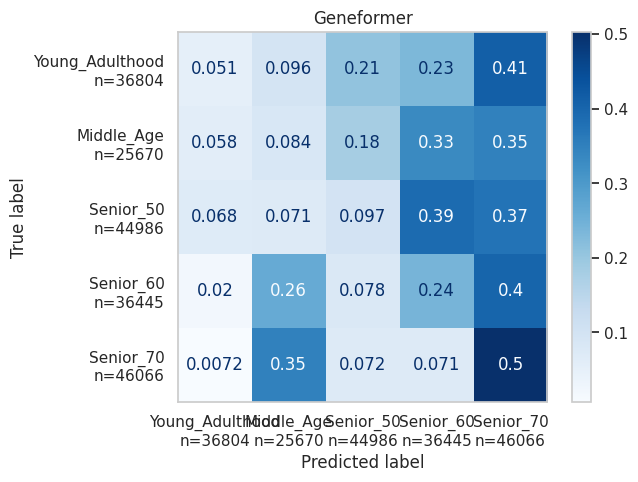

In [31]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory="/hpcfs/users/a1841503/trained_classifiers/agebins_classifier_v1_cellnexus/250910214929/",
        output_prefix=output_prefix,
        custom_class_order=["Young_Adulthood","Middle_Age", "Senior_50", "Senior_60", "Senior_70"],
)


<Figure size 1500x1500 with 0 Axes>

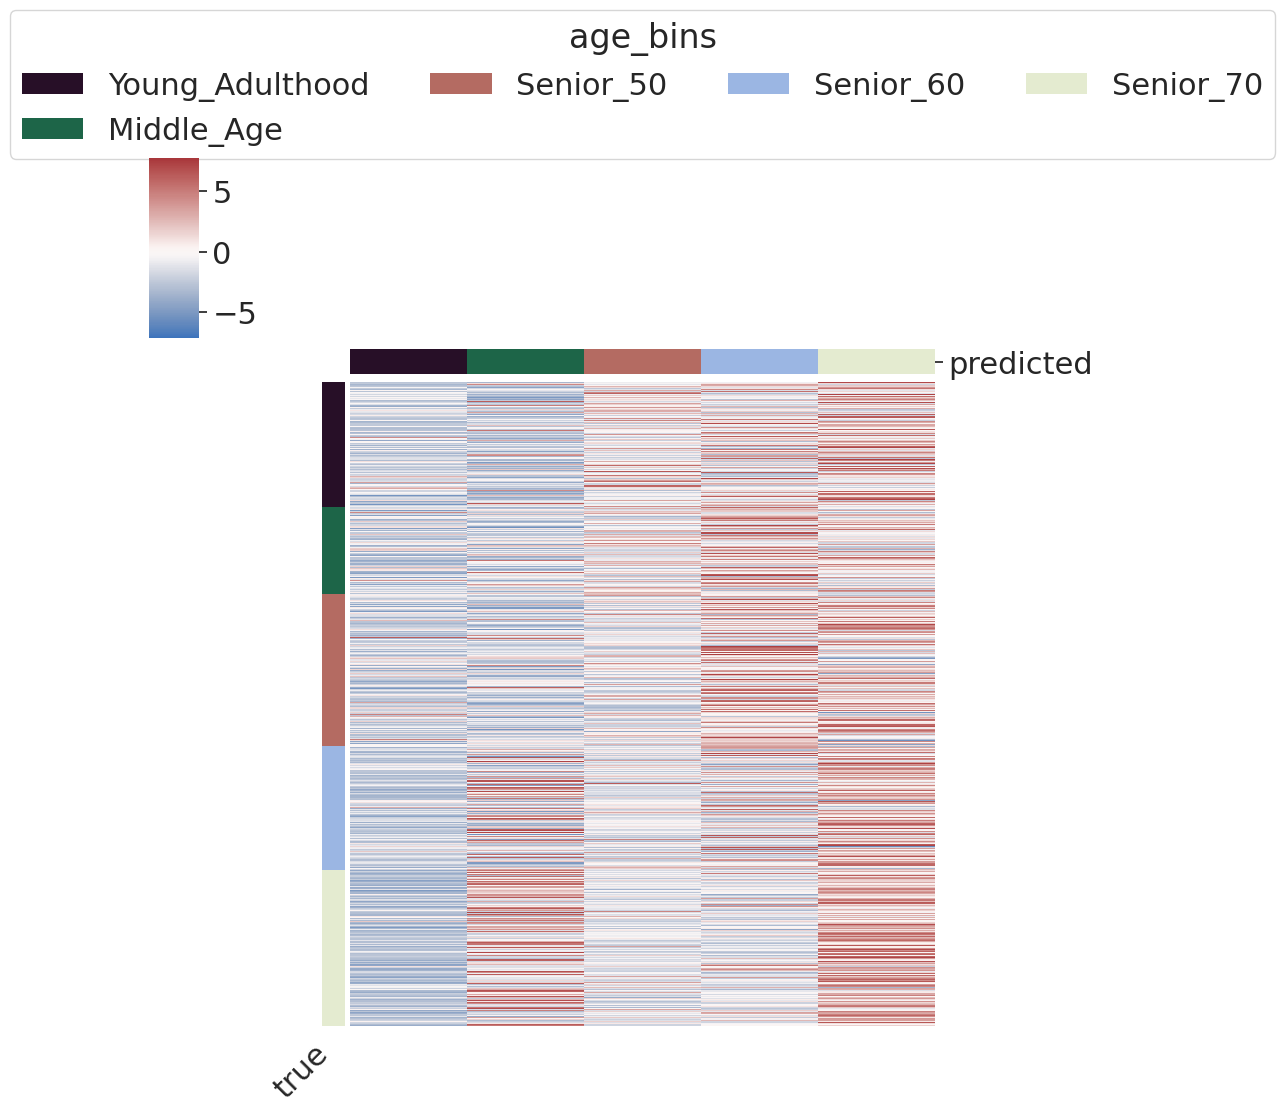

In [33]:
cc.plot_predictions(
    predictions_file=f"/hpcfs/users/a1841503/trained_classifiers/agebins_classifier_v1_cellnexus/250910214929/age_bins_classifier_cellnexus_blood_cell_type_as_covariate_pred_dict.pkl",
    id_class_dict_file=f"/hpcfs/users/a1841503/trained_classifiers/agebins_classifier_v1_cellnexus/250910214929/age_bins_classifier_cellnexus_blood_cell_type_as_covariate_id_class_dict.pkl",
    title="age_bins",
    output_directory="/hpcfs/users/a1841503/trained_classifiers/agebins_classifier_v1_cellnexus/250910214929/",
    output_prefix=output_prefix,
    custom_class_order=["Young_Adulthood","Middle_Age", "Senior_50", "Senior_60", "Senior_70"],
)

In [34]:
all_metrics_test

{'conf_matrix':                  Senior_70  Senior_50  Middle_Age  Young_Adulthood  Senior_60
 Senior_70            23165       3322       15977              332       3270
 Senior_50            16822       4353        3186             3072      17553
 Middle_Age            8895       4651        2151             1483       8490
 Young_Adulthood      15170       7672        3527             1883       8552
 Senior_60            14611       2840        9514              723       8757,
 'macro_f1': 0.173467193466695,
 'acc': 0.21218501771322992,
 'all_roc_metrics': None}